In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
from zipfile import ZipFile
import shutil
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

from utils import test_case_checker, perform_computation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# *Assignment Summary

This is an exercise from the textbook (8.3.2. Example: Activity from Accelerometer Data):

Obtain the activities of daily life dataset from the UC Irvine machine learning website (https://archive.ics.uci.edu/ml/datasets/Dataset+for+ADL+Recognition+with+Wrist-worn+Accelerometer, data provided by Barbara Bruno, Fulvio Mastrogiovanni and Antonio Sgorbissa).
  1. Build a classifier that classifies sequences into one of the 14 activities provided. To make features, you should vector quantize, then use a histogram of cluster centers found through hierarchical k-means. For classification, any multi-class classifier works, but in this assignment we will use a decision forest because it is easy to use and effective. You should report (a) the total error rate and (b) the class confusion matrix of your classifier.
  2. Now see if you can improve your classifier by (a) modifying the number of cluster centers in your hierarchical k-means and (b) modifying the size of the fixed length samples that you use.

Questions about the homework:

  1. How should we handle test/train splits?
  
  **Answer**: You should not test on examples that you used to build the dictionary, but you can train on them. In a perfect world, I would split the volunteers into a dictionary portion (about half), then do a test/train split for the classifier on the remaining half. You can't do that, because for some signals there are very few volunteers. For each category, choose 20% of the signals (or close!) for testing. Then use the others to both build the dictionary and build the classifier.

  2. When we carve up the signals into blocks for making the dictionary, what do we do about leftover bits at the end of the signal?
  
  **Answer**: Ignore them; they shouldn't matter (think through the logic of the method again if you're uncertain about this)
  

<font color='red'> <b>Attention:</b> </font> After finishing this notebook, you will need to do a follow-up quiz as well. The overall grade for this asiggnment is based on this notebook and the follow-up quiz.
    
<font color='red'><b> Warning: </b></font> Using the "Validate" button for this assignment may lead to a timeout, please do not use it.

# 0. Data

## 0.1 Description

We'll use the activities of daily life dataset from the UC Irvine machine learning website (https://archive.ics.uci.edu/ml/datasets/Dataset+for+ADL+Recognition+with+Wrist-worn+Accelerometer).
The data was provided by Barbara Bruno, Fulvio Mastrogiovanni and Antonio Sgorbissa

## 0.2 Information Summary

* **Input/Output**: The data includes 14 directories, each of which represents a certain daily activity. There are 839 accelerometer recordings in the dataset, each with 3 columns and some number of rows. The sampling frequency of the device was 32 samples per second.

* **Missing Data**: There is no missing data. However, the data is not very well balanced, and some categories have really small amounts of data.

* **Final Goal**: We want to build a classifier using vector quantization and other techniques.

## 0.3 Loading the Data

In [ ]:
# Let's extract the data
with ZipFile('hmpdata.zip', 'r') as zipObj:
    zipObj.extractall()

In [ ]:
# Loading the data into lists of lists
col_labels = ['X','Y','Z']
raw_txt_files = []
activity_labels = ['Liedown_bed', 'Walk', 'Eat_soup', 'Getup_bed', 'Descend_stairs', 
                   'Use_telephone', 'Standup_chair', 'Brush_teeth', 'Climb_stairs', 
                   'Sitdown_chair', 'Eat_meat', 'Comb_hair', 'Drink_glass', 'Pour_water']

for activity in activity_labels:
    activity_txts = []
    for file in os.listdir('HMP_Dataset/'+activity):
        txtdf = pd.read_csv('HMP_Dataset/'+activity+'/'+file, names=col_labels,  sep=" ")
        activity_txts.append(txtdf)
    raw_txt_files.append(activity_txts)

In [ ]:
# Let's clean up after we're done
shutil.rmtree('./HMP_Dataset')

In [ ]:
print('Number of samples for each activity:')
for activity, activity_txts in zip(activity_labels, raw_txt_files):
    print(f'    {activity}: {len(activity_txts)}')
print(f'Total number of samples: {sum(len(activity_txts) for activity_txts in raw_txt_files)}')

Number of samples for each activity:
    Liedown_bed: 28
    Walk: 100
    Eat_soup: 3
    Getup_bed: 101
    Descend_stairs: 42
    Use_telephone: 13
    Standup_chair: 102
    Brush_teeth: 12
    Climb_stairs: 102
    Sitdown_chair: 100
    Eat_meat: 5
    Comb_hair: 31
    Drink_glass: 100
    Pour_water: 100
Total number of samples: 839


## 0.4 Creating a Random Train-Test Split

It is not wise to out-source this train-test split to traditional sklearn functions as the data is a bit unique (not in a data matrix format), and also balancing the data in the small sample classes requires some delicacy.

In [ ]:
test_portion = 0.2

In [ ]:
np_random = np.random.RandomState(12345)
train_val_txt_files = []
test_txt_files = []
for _,activity_txt_files in enumerate(raw_txt_files):
    num_txt_files = len(activity_txt_files)
    shuffled_indices = np.arange(num_txt_files)
    np_random.shuffle(shuffled_indices)
    
    train_val_txt_files.append([])
    test_txt_files.append([])
    for i, idx in enumerate(shuffled_indices):
        if i < test_portion * num_txt_files:
            test_txt_files[-1].append(activity_txt_files[idx])
        else:
            train_val_txt_files[-1].append(activity_txt_files[idx])

# 1. Training

For now, we'll assume the following two hyper-parameters:
1. `d`: This is the vector quantization length in the number of rows. This default value of 32 corresponds to about 1 full second of observation.
2. `k`: This is the number of K-Means clusters for creating features using cluster histograms.

Since we do not want to engage in any hyper-parameter tuning yet, we will use the whole `train_val_txt_files` data for just training.

In [ ]:
d = 32
k = 100
train_txt_files = train_val_txt_files

# <span style="color:blue">Task 1</span>

Write a vector-quantization function `quantize` that takes two arguments as input

1. `X`: a numpy array with the shape $(N, 3)$, where $N$ is the number of samples in a single recording. The columns represent the acceleration in each of the $x$, $y$, and $z$ directions. For example, we could have the X matrix as follows
$$X_{135\times 3} = \begin{bmatrix}
x_1 & y_1 & z_1\\
x_2 & y_2 & z_2\\
\cdots\\
x_{135} & y_{135} & z_{135}\\
\end{bmatrix}$$
2. `d`: This is the number of consecutive samples for each segment in the output.

and returns the variable `out`, which arranges the vector into segments of size `d` and drops any incomplete final set of data. For instance, in our previous example we should have
$$\textit{out}_{4\times 96} = 
\begin{bmatrix}
x_1 & y_1 & z_1 & x_2 & y_2 & z_2 & \cdots & x_{32}& y_{32} & z_{32}\\
\cdots\\
x_{97} & y_{97} & z_{97} & x_{98} & y_{98} & z_{98} & \cdots & x_{128}& y_{128} & z_{128}\\
\end{bmatrix}$$
Each row is a segment of 32 consecutive samples (each sample with their corresponding $x_i$, $y_i$, $z_i$ acceleration measurements).

In [ ]:
def quantize(X, d=32):
    assert X.ndim == 2
    assert X.shape[1] == 3
    
    # your code here
    out = X[:((X.shape[0] * X.shape[1]) // (3*d)) * d,:].reshape(-1, 3*d)
    
    assert out.shape[1] == 3*d
    return out

In [ ]:
some_data = (np.arange(135*3).reshape(-1,3) ** 13) % 20
some_q_data = quantize(some_data, d=32)
assert np.array_equal(some_q_data, np.array([[ 0,  1, 12,  3,  4,  5, 16,  7,  8,  9,  0, 11, 12, 13,  4, 15,
                                               16, 17,  8, 19,  0,  1, 12,  3,  4,  5, 16,  7,  8, 13,  4, 15,
                                               0,  5,  0, 19, 12,  9,  4,  3,  4,  1,  8, 15,  8, 17, 12, 11,
                                               4,  5,  8, 15,  0, 17,  4, 15,  8, 17, 16,  3,  0,  9,  8,  7,
                                               0, 17,  8,  7,  0,  1, 16, 11,  8, 17,  8,  7,  8,  1, 16, 19,
                                               12,  5,  4,  3, 12,  5,  8,  7, 16,  9, 12, 11,  8, 13,  8,  7],
                                             [ 0,  5,  4,  3,  4,  5, 16, 11, 12,  1,  4, 11,  8,  9,  0,  7,
                                               8, 17, 12, 11, 16,  5,  8,  7, 12, 17,  0, 11,  8, 17,  0,  7,
                                               0,  5, 16, 19, 16,  1,  8, 11,  8, 13, 16, 11,  4, 13, 16, 11,
                                               12, 13,  4, 15, 12, 13,  4, 15, 16,  9,  0,  3, 16, 17,  0,  3,
                                               0,  5, 16, 15,  8,  1,  8, 19, 12,  5,  0,  7,  8, 13, 12, 19,
                                               16,  9, 12, 15,  8,  1, 16, 19,  0, 13,  0, 19, 12, 17,  0,  3],
                                             [ 0,  5, 16, 19, 16,  9,  0,  3,  0, 17,  8, 15, 16, 17, 12, 19,
                                               8, 17,  8, 19, 16, 13,  0,  7, 12,  5, 12, 11, 16,  9,  4, 19,
                                               0,  9,  0, 15, 12,  9,  8, 11,  8,  9,  8, 15, 16,  9,  4, 11,
                                               4, 13,  8, 15, 12, 13,  4, 11,  0,  1,  4, 15,  0, 17,  8, 15,
                                               0,  5,  0, 15, 12, 13, 16,  3,  8,  1,  4, 15,  0,  5,  0, 11,
                                               12,  9,  8, 19,  8, 17, 12, 15, 12, 17,  0,  7,  4, 17,  0, 15],
                                             [ 0, 17, 12,  7, 12, 17,  8, 15,  8, 13, 16, 11, 12,  1,  0,  7,
                                               4,  9,  4, 19,  8,  5, 12,  3, 12,  1, 16,  3,  8,  9,  8, 11,
                                               0, 17,  4, 19,  8,  5,  8, 15,  4, 17, 16,  7,  8,  5,  0, 15,
                                               16,  9,  4,  3,  0,  1,  8, 15, 12, 13,  4, 19,  4,  1,  0,  3,
                                               0,  1,  0, 11, 16,  9,  8, 15,  0, 13,  4, 15,  8, 17, 12,  3,
                                               8,  1,  8, 11,  0,  9, 12, 15, 16,  9, 12,  7,  0,  9,  8, 19]]))

# Checking against the pre-computed test database
test_results = test_case_checker(quantize, task_id=1)
assert test_results['passed'], test_results['message']

In [ ]:
quantized_data_for_clustering = []
for activity_idx, activity_txt_files in enumerate(train_txt_files):
    for txt_df in activity_txt_files:
        quantized_text = quantize(txt_df.values, d=d)
        quantized_data_for_clustering.append(quantized_text)
quantized_data_for_clustering = np.concatenate(quantized_data_for_clustering, axis=0)

# <span style="color:blue">Task 2</span>

Using Scikit-learn's KMeans implementation, learn a K-Means clusterer. Write the function `train_kmeans_model` to get the training data `data` and `k` as arguments, and produce a SKLearn's KMeans object with `k` clusters that was trained on `data`.

**Important**: You should use 12345 as the `random_state` variable for the sake of auto-grading. 

In [ ]:
def train_kmeans_model(data, k):
    
    # your code here
    kmeans_model = KMeans(n_clusters=k, random_state=12345).fit(data)
    
    return kmeans_model

In [ ]:
kmeans_model = train_kmeans_model(quantized_data_for_clustering, k)

assert kmeans_model.n_clusters == k
assert kmeans_model.random_state == 12345

# <span style="color:blue">Task 3</span>

Using the `quantize` function you wrote before, write the new function `text2hist` that converts the data previously obtained from text files into a set of features using the K-Means model you have already trained.

First, quantize the data. This should give you a matrix `quantized_data` with multiple rows which can then be fed to the K-Means clusterer. The output of the K-Means prediction `km_pred` has the same length as the number of rows in `quantized_data`, you should treat it as a set of samples. You should create a normalized count vector of length $k$. For normalization, consider that the prediction classes range between $0$ and $k-1$ in value. This normalized count vector would be your output. 

The inputs are:
1. `X`: 1. `X`: a numpy array with the shape $(N, 3)$, where $N$ is the number of samples in a single recording. The columns represent the acceleration in each of the $x$, $y$, and $z$ directions. This is the same kind of input that was given to the `quantize` function.
2. `kmeans_model`: This is a trained scikit-learn K-Means object that you could use for prediction.
2. `d`: This is the vector quantization length.
3. `k`: This is the number of clusters.

The output should be a histogram `hist`; A numpy array with the shape of $(k,)$, and non-negative elements that should sum up to 1.

**Hint**: Numpy functions like `np.bincount` or `np.histogram` maybe useful for histogram production if you know how to use them.

In [ ]:
def text2hist(X, kmeans_model, d, k):
    assert X.ndim == 2
    assert X.shape[1] == 3
    assert kmeans_model.cluster_centers_.shape == (k, 3*d)
    
    # your code here
    quantized_data = quantize(X, d)
    hist, km_pred = np.histogram(kmeans_model.predict(quantized_data), bins=[i for i in range(k+1)], density=True)
    
    assert hist.ndim == 1
    assert hist.size == k
    assert np.sum(hist).round(2) == 1.
    return hist

In [ ]:
some_data = (np.arange(135*3).reshape(-1,3) ** 13) % 20
some_hist = text2hist(some_data, kmeans_model, d, k)
assert some_hist[some_hist>0].size == 1


## 1.1 Creating the features

In [ ]:
def feature_maker(txt_files, kmeans_model, d, k):
    features = []
    labels = []
    for activity_idx, activity_txt_files in enumerate(txt_files):
        for txt_df in activity_txt_files:
            feature_vec = text2hist(txt_df.values, kmeans_model, d=d, k=k)
            features.append(feature_vec.reshape(1,-1))
            labels.append(activity_idx)
    features = np.concatenate(features, axis=0)
    labels = np.array(labels)
    return features, labels

In [ ]:
train_features, train_labels = feature_maker(train_txt_files, kmeans_model, d, k)

# 1.2 Training the Classifier

# <span style="color:blue">Task 4</span>

Using Scikit-learn's implementation, train a Random Forest classifier. Write the function `train_classifier` to get the training data `train_features` and `train_labels` as arguments, and return a SKLearn's `RandomForestClassifier` object that was trained on `data`. Use 100 trees for building the random forest.

**Important**: You should use 12345 as the `random_state` variable for the sake of auto-grading. 

In [ ]:
def train_classifier(train_features, train_labels):
    
    # your code here
    classifier = RandomForestClassifier(n_estimators=100, random_state=12345).fit(train_features, train_labels)
    
    return classifier

In [ ]:
classifier = train_classifier(train_features, train_labels)
assert classifier.n_estimators == 100
assert classifier.random_state == 12345



In [ ]:
train_pred = classifier.predict(train_features)
print(f' Training accuracy: {np.mean(train_pred==train_labels)}')

 Training accuracy: 0.9984984984984985


In [ ]:
test_features, test_labels = feature_maker(test_txt_files, kmeans_model, d, k)
test_pred = classifier.predict(test_features)
print(f' Testing accuracy: {np.mean(test_pred==test_labels)}')

 Testing accuracy: 0.7514450867052023


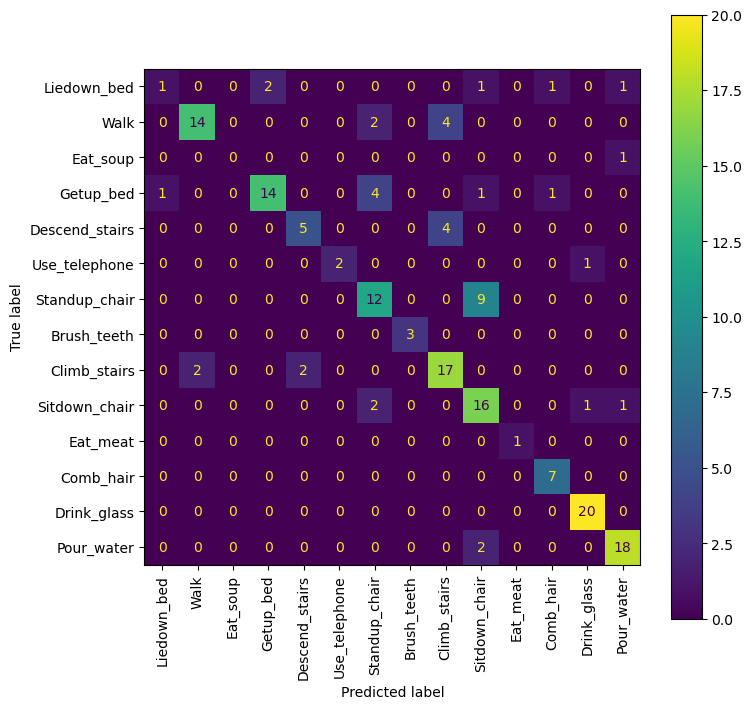

In [ ]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(8,8), dpi=100)
plot_confusion_matrix(classifier, test_features, test_labels, 
                      display_labels=activity_labels, 
                      xticks_rotation = 'vertical', ax=ax)

# 2. Hyperparameter tuning

The following function only combines what we already have done so far. It essentially takes the training and test data, along with the choice of `d` and `k` hyperparameters, trains a model, and then returns the test accuracy.

In [ ]:
def train_and_evaluate(train_txt_files, test_txt_files, d, k, plot_confusion_mat=False):
    quantized_data_for_clustering = []
    for activity_idx, activity_txt_files in enumerate(train_txt_files):
        for txt_df in activity_txt_files:
            quantized_text = quantize(txt_df.values, d=d)
            quantized_data_for_clustering.append(quantized_text)
    quantized_data_for_clustering = np.concatenate(quantized_data_for_clustering, axis=0)

    kmeans_model = train_kmeans_model(quantized_data_for_clustering, k)

    train_features, train_labels = feature_maker(train_txt_files, kmeans_model, d, k)

    classifier = train_classifier(train_features, train_labels)

    test_features, test_labels = feature_maker(test_txt_files, kmeans_model, d, k)
    test_pred = classifier.predict(test_features)
    test_acc = np.mean(test_pred==test_labels)
    
    if plot_confusion_mat:
        fig, ax = plt.subplots(figsize=(8,8), dpi=100)
        plot_confusion_matrix(classifier, test_features, test_labels, 
                              display_labels=activity_labels, 
                              xticks_rotation = 'vertical', ax=ax)
    
    return test_acc

## 2.1 Cross-Validation

<font color='red'> <b>Attention: </b> </font> The followup quiz of this assignment will ask some questions about performance in cross-validation. Although you are not implementing this part, you may want to come back here to do some calculations to get answers for the questions in the quiz.

<font color='red'><b> Warning: </b></font> Using the "Validate" button for this assignment may lead to a timeout, please do not use it.

### 2.1.1 Getting a Dry Run

First, let's create a tiny version of our dataset with at most 5 training items per class. Since running a 5 or 10-fold cross-validation would be extremely time consuming, we are running a 3-fold cross-validation.

In [ ]:
def generate_cv_pairs(train_val_txt_files, cv_folds=3):
    cross_val_pairs = []
    for fold_idx in range(cv_folds):
        train_cv_files = []
        val_cv_files = []
        for activity_idx, activity_txt_files in enumerate(train_val_txt_files):
            train_cv_files.append([])
            val_cv_files.append([])
            for i, txt_df in enumerate(activity_txt_files):
                if float(fold_idx+1)/cv_folds > float(i)/len(activity_txt_files) >= float(fold_idx)/cv_folds:
                    val_cv_files[-1].append(txt_df)
                else:
                    train_cv_files[-1].append(txt_df)
        cross_val_pairs.append((train_cv_files,val_cv_files))
    return cross_val_pairs

def perform_cross_validation(cross_val_pairs, k_list, d_list):
    kd_acc = dict()
    for k_candidate in k_list:
        for d_candidate in d_list:
            fold_accs = []
            for train_txt_files, val_txt_files in cross_val_pairs:
                print('.', end='')
                fold_acc = train_and_evaluate(train_txt_files, val_txt_files, d_candidate, k_candidate)
                fold_accs.append(fold_acc)
            cv_acc = np.mean(fold_accs)

            kd_acc[(k_candidate, d_candidate)] = cv_acc
        print('')
    return kd_acc

In [ ]:
# List of k and d candidates for performing hyper-parameter optimization using Cross-Validation
k_list = [50, 200, 500]
d_list = [8, 16, 32, 64]

In [ ]:
if perform_computation:
    train_val_txt_files_tiny = [x[:5] for x in train_val_txt_files]
    test_txt_files_tiny = [x[:5] for x in test_txt_files]
    cross_val_pairs_tiny = generate_cv_pairs(train_val_txt_files_tiny, cv_folds=3)
    kd_acc = perform_cross_validation(cross_val_pairs_tiny, k_list=k_list, d_list=d_list)

.......

In [ ]:
if perform_computation:
    fig, ax = plt.subplots(figsize=(10,8), dpi=100)
    for (k_,d_), acc_ in kd_acc.items():
        ax.scatter([k_], [d_])
        ax.annotate('%.1f'%(acc_*100.) + '%', (k_-int((max(k_list)-min(k_list))*0.022), d_*1.03))
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Vector Quantization Length')
    ax.set_yscale('symlog', base=2)
    ax.set_yticks(d_list)
    from matplotlib.ticker import ScalarFormatter
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(axis='y', style='plain')
    _ = ax.set_title('Cross-Validation Accuracy Values (*Dry Run)')

In [ ]:
if perform_computation:
    (best_k, best_d), best_cv_acc = max(kd_acc.items(), key=lambda tup_: tup_[1])
    test_acc = train_and_evaluate(train_val_txt_files_tiny, test_txt_files_tiny, best_d, best_k, plot_confusion_mat=True)
    print(f'Best Number of Clusters (*Dry Run): k={best_k}')
    print(f'Best Quantization Length (*Dry Run): d={best_d}')
    print(f'Tuned Test Accuracy (*Dry Run): {test_acc}')

### 2.1.2 Getting a More Serious Run

Now we will perform cross-validation with the full set of samples.

The following may take up to an hour, so please be patient...

In [ ]:
# List of k and d candidates for performing hyper-parameter optimization using Cross-Validation
k_list = [50, 200, 500]
d_list = [8, 16, 32, 64]

In [ ]:
if perform_computation:
    cross_val_pairs = generate_cv_pairs(train_val_txt_files, cv_folds=3)
    kd_acc = perform_cross_validation(cross_val_pairs, k_list=k_list, d_list=d_list)

In [ ]:
if perform_computation:
    fig, ax = plt.subplots(figsize=(10,8), dpi=100)
    for (k_,d_), acc_ in kd_acc.items():
        ax.scatter([k_], [d_])
        ax.annotate('%.1f'%(acc_*100.) + '%', (k_-int((max(k_list)-min(k_list))*0.022), d_*1.03))
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Vector Quantization Length')
    ax.set_yscale('symlog', base=2)
    ax.set_yticks(d_list)
    from matplotlib.ticker import ScalarFormatter
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(axis='y', style='plain')
    _ = ax.set_title('Cross-Validation Accuracy Values')

In [ ]:
if perform_computation:
    (best_k, best_d), best_cv_acc = max(kd_acc.items(), key=lambda tup_: tup_[1])
    test_acc = train_and_evaluate(train_val_txt_files, test_txt_files, best_d, best_k, plot_confusion_mat=True)
    print(f'Best Number of Clusters: k={best_k}')
    print(f'Best Quantization Length: d={best_d}')
    print(f'Tuned Test Accuracy: {test_acc}')